# Set Up

imports, configuration, table (Asset) loading

In [1]:
#importstatements
import matplotlib.pyplot as plt
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import *
import pyspark.sql.functions as F     
from pyspark.sql import types 
from pyspark.sql.types import StructField, StringType, LongType, DoubleType, BooleanType, StructType, IntegerType   

from pyspark.sql.functions import col, hex, base64, avg, collect_list, concat, lit, max


In [2]:
#config for the sparksession
config = pyspark.SparkConf().setAll([
    ('spark.executor.memory', '12g'), 
    ('spark.executor.cores', '2'), 
    ('spark.cores.max', '4'),
    ('spark.driver.memory','2g'),
    ('spark.executor.instances', '1'),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('spark.dynamicAllocation.shuffleTracking.enabled', 'true'),
    ('spark.dynamicAllocation.executorIdleTimeout', '60s'),
    ('spark.dynamicAllocation.minExecutors', '0'),
    ('spark.dynamicAllocation.maxExecutors', '2'),
    ('spark.dynamicAllocation.initialExecutors', '1'),
    ('spark.dynamicAllocation.executorAllocationRatio', '1'),
    ('spark.worker.cleanup.enabled', 'true'),
    ('spark.worker.cleanup.interval', '60'),
    ('spark.shuffle.service.db.enabled', 'true'),
    ('spark.worker.cleanup.appDataTtl', '60'),
    ('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector:10.0.2')
])

In [3]:
#create sparksession
spark = SparkSession \
    .builder \
    .config(conf=config) \
    .appName("5_countFT_NFT") \
    .master("spark://172.23.149.212:7077") \
    .getOrCreate()

22/07/11 12:31:46 WARN Utils: Your hostname, algorand-druid-and-spark resolves to a loopback address: 127.0.0.1; using 172.23.149.212 instead (on interface ens3)
22/07/11 12:31:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ubuntu/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.mongodb.spark#mongo-spark-connector added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-72c3a167-ae55-45bc-9eb4-0e0696e64b19;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector;10.0.2 in central
	found org.mongodb#mongodb-driver-sync;4.5.1 in central
	[4.5.1] org.mongodb#mongodb-driver-sync;[4.5.0,4.5.99)
	found org.mongodb#bson;4.5.1 in central
	found org.mongodb#mongodb-driver-core;4.5.1 in central
:: resolution report :: resolve 2818ms :: artifacts dl 13ms
	:: modules in use:
	org.mongodb#bson;4.5.1 from central in [default]
	org.mongodb#mongodb-driver-core;4.5.1 from central in [default]
	org.mongodb#mongodb-driver-sync;4.5.1 from central in [default]
	org.mongodb.spark#mongo-spark-connector;10.0.2 from central in [default]
	---------------------------------------------------------------------
	|                  | 

In [37]:
#create a schema so data quality of dfAsset is ensured
schema = StructType([ \
    StructField("df", BooleanType(), True), \
    StructField("closed_at", LongType(), True), \
    StructField("c", StringType(), True), \
    StructField("f", StringType(), True), \
    StructField("index", LongType(), True), \
    StructField("created_at", LongType(), True), \
    StructField("am", StringType(), True), \
    StructField("an", StringType(), True), \
    StructField("m", StringType(), True), \
    StructField("r", StringType(), True), \
    StructField("deleted", BooleanType(), True), \
    StructField("t", LongType(), True), \
    StructField("au", StringType(), True), \
    StructField("un", StringType(), True), \
    StructField("creator_addr", StringType(), True), \
    StructField("dc", LongType(), True), \
])

In [38]:
#getting asset table
dfAsset = spark.read.format("mongodb") \
    .option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
    .option('spark.mongodb.database', 'algorand') \
    .option('spark.mongodb.collection', 'asset') \
    .option('park.mongodb.read.readPreference.name', 'primaryPreferred') \
    .option('spark.mongodb.change.stream.publish.full.document.only','true') \
    .option("forceDeleteTempCheckpointLocation", "true") \
    .schema(schema) \
    .load()

# Distinction of Assets

In Algorand it is possible to distinguish between NFT, FT. Additionally it can be detected which assets were deleted. When looking on the deleted assets it cannot be distinguished between NFT and FTs, because the corresponding variables are set to null

In [39]:
#if amount of assets is exactly one than it has to be an NFT
dfAsset= dfAsset.drop("dc", "df", "_id")

dfNFT = dfAsset.where(dfAsset.t == 1)

dfFT = dfAsset.where((dfAsset.t != 1 )& (dfAsset.t.isNotNull()))

dfDeleted = dfAsset.where(dfAsset.deleted == "true")

#dfUsers = dfAccounts.where((dfAccounts.rewards_total == 0) & (dfAccounts.deleted == False))
NFTcount = dfNFT.count()
FTcount = dfFT.count()
DelCount = dfDeleted.count()


basic statistic results are added to the gold table. The gold table is not overwritten but appended. The data is written to the gold table with a time stamp. The time stamp is the last block which the data has.

In [6]:
#newest round for writing to the gold table
newestRound = dfAsset.agg(F.max("created_at")).collect()[0][0]

In [7]:
#write amount of Algos in gold table
#first put value in a df
result = spark.createDataFrame(
    [
        (NFTcount, FTcount, DelCount, newestRound)  # create your data here, be consistent in the types.
        
    ],
    ["AmountOfNFT", "AmountOfFT", "AmountOfDeletedAssets", "CreationRound"]  # add your column names here
)

result.write.format("mongodb") \
	.option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
  	.mode("append") \
    .option('spark.mongodb.database', 'algorand_gold') \
  	.option('spark.mongodb.collection', 'AssetsOverview_5') \
  	.option("forceDeleteTempCheckpointLocation", "true") \
  	.save()

22/07/11 12:35:18 WARN CaseInsensitiveStringMap: Converting duplicated key forcedeletetempcheckpointlocation into CaseInsensitiveStringMap.


# Graphs Based on Blockrounds

### NFT Graph

In [8]:
#all people that have created an NFT on which time
graph = dfNFT.select("created_at")

#preparation for graph
graph = graph.collect()

#convert row["data"] to only data
roundsNFT = [row[0] for (row) in graph]


In [9]:
#min
minNFTrounds = dfNFT.agg(F.min("created_at")).collect()[0][0]
maxNFTrounds = dfNFT.agg(F.max("created_at")).collect()[0][0]

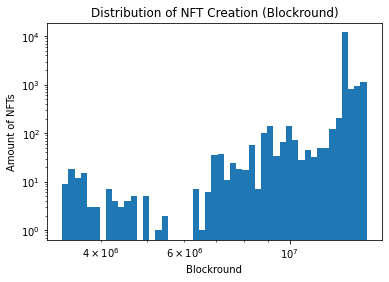

In [10]:
#histogram x-axis round when creating NFT
#only the NFTs are taken into consideration, which are not already deleted
#the plot is saved to the VM
bin_size = 50
#distribute bins log(equally) over the whole data
mybins = np.logspace(np.log10(minNFTrounds), np.log10(maxNFTrounds), bin_size )

plt.figure()
plt.hist(roundsNFT, bins = mybins)
plt.rcParams["figure.autolayout"] = True
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Blockround")
plt.ylabel("Number of NFTs")
plt.title("Distribution of NFT Creation (Blockround)", loc ='center', pad = None)
plt.savefig('/home/ubuntu/apps/figures/5_countNFT/distribution_of_NFT_creation_perRound.jpg', dpi= 200)
plt.show()
plt.close()

### FT Graph

In [11]:
#all people that have created an FT on which time
graphFTround = dfFT.select("created_at")

#preparation for graph
graphFTround = graphFTround.collect()

#convert row["data"] to only data
roundsFT = [row[0] for (row) in graphFTround]


In [12]:
#min
minFTrounds = dfFT.agg(F.min("created_at")).collect()[0][0]
maxFTrounds = dfFT.agg(F.max("created_at")).collect()[0][0]

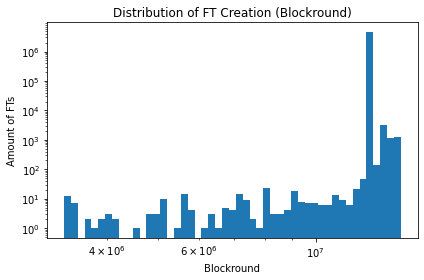

In [13]:
#histogram x-axis round when creating NFT
bin_size = 50
#distribute bins log(equally) over the whole data
mybins = np.logspace(np.log10(minFTrounds), np.log10(maxFTrounds), bin_size )

plt.figure()
plt.hist(roundsFT, bins = mybins)
plt.rcParams["figure.autolayout"] = True
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Blockround")
plt.ylabel("Number of FTs")
plt.title("Distribution of FT Creation (Blockround)", loc ='center', pad = None)
plt.savefig('/home/ubuntu/apps/figures/5_countNFT/distribution_of_FT_creation_perRound.jpg', dpi= 200)
plt.show()
plt.close()

### NFT vs FT Graph: creation over blockround

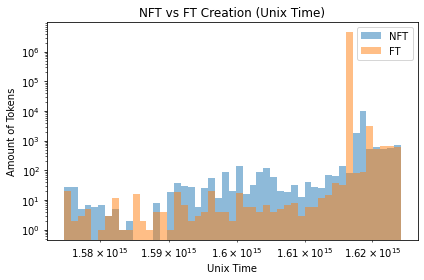

In [23]:
#histogram x-axis round when creating NFT
#only tokens taken into consideration which are still online
#the graph is saved on the vm
bin_size = 50
#distribute bins log(equally) over the whole data
mybins = np.logspace(np.log10(minFTrounds), np.log10(maxFTrounds), bin_size)

plt.figure()
plt.hist(roundsNFT, bins = mybins, alpha =0.5, label = "NFT")
plt.hist(roundsFT, bins = mybins, alpha =0.5, label = "FT")
plt.rcParams["figure.autolayout"] = True
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Blockround")
plt.ylabel("Number of Tokens")
plt.legend(loc="upper right")
plt.title("NFT vs FT Creation (Blockround)", loc ='center', pad = None)
plt.savefig('/home/ubuntu/apps/figures/5_countNFT/NFT_vs_FT_creation_Blockround.jpg', dpi= 200)
plt.show()
plt.close()

### Unix Time silver table

the assets have to be joined with the block, so the realtime / unixtime can be added to the silvertable

In [14]:
#the expression can also be done in time
#get BlockHeader to know the Realtime of a Block
dfBlock = spark.read.format("mongodb") \
    .option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
    .option('spark.mongodb.database', 'algorand') \
    .option('spark.mongodb.collection', 'block_header') \
    .option('park.mongodb.read.readPreference.name', 'primaryPreferred') \
    .option('spark.mongodb.change.stream.publish.full.document.only','true') \
    .option("forceDeleteTempCheckpointLocation", "true") \
    .load()

#select necessary schema
dfBlock = dfBlock.select(col("round").alias("blockround"), col("realtime"))

In [15]:
#add time to dfTx, where the information about online and offline is stored
dfNFT = dfBlock.join(dfNFT, dfBlock.blockround == dfNFT.created_at, "inner")
#the same for FT
dfFT = dfBlock.join(dfFT, dfBlock.blockround == dfFT.created_at, "inner")


save the newly created df in the silvertable, so the NFT and FT are saved with a unixtime stamp

In [16]:
#post the dfNFT and dfFT in the silvertable after joining
dfNFT.write.format("mongodb") \
	.option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
  	.mode("overwrite") \
    .option('spark.mongodb.database', 'algorand_silver') \
  	.option('spark.mongodb.collection', 'NFT_creationTimeInSec_5') \
  	.option("forceDeleteTempCheckpointLocation", "true") \
  	.save()

dfFT.write.format("mongodb") \
	.option('spark.mongodb.connection.uri', 'mongodb://172.23.149.212:27017') \
  	.mode("overwrite") \
    .option('spark.mongodb.database', 'algorand_silver') \
  	.option('spark.mongodb.collection', 'FT_creationTimeInSec_5') \
  	.option("forceDeleteTempCheckpointLocation", "true") \
  	.save()

22/07/11 12:41:15 WARN CaseInsensitiveStringMap: Converting duplicated key forcedeletetempcheckpointlocation into CaseInsensitiveStringMap.
22/07/11 12:43:28 WARN CaseInsensitiveStringMap: Converting duplicated key forcedeletetempcheckpointlocation into CaseInsensitiveStringMap.


# Token creation vs deletion Graph over blockround

### preparation for creating the graph

In [24]:
#creation (incl. live) vs deleted #unterscheidung zwischen nft und ft nicht möglich weil deletion t == null
#preparation for histogram when all assets are created and when all assets are deleted
dfCreated = dfAsset.where(dfAsset.t.isNotNull())

#preparation for histogram when all assets are created and when all assets are deleted
graphCreated = dfCreated.select("created_at")

#preparation for graph
graphCreated = graphCreated.collect()

#convert row["data"] to only data
roundsCreated = [row[0] for (row) in graphCreated]

The df shows all tokens which were deleted

In [44]:
#preparation for histogram when all assets are created and when all assets are deleted
graphDeleted = dfDeleted.select("closed_at")
graphDeleted = graphDeleted.collect()

#convert row["data"] to only data
roundsDeleted = [row[0] for (row) in graphDeleted]

In [26]:
#min
minRounds = dfAsset.agg(F.min("created_at")).collect()[0][0]
maxRounds = dfAsset.agg(F.max("created_at")).collect()[0][0]

### creation of graph: Token creation vs deletion over blockround

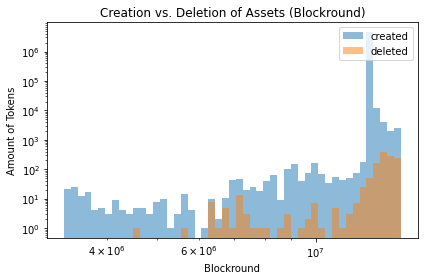

In [46]:
#histogram when all assets are created and when all assets are deleted
bin_size = 50
#distribute bins log(equally) over the whole data
mybins = np.logspace(np.log10(minRounds), np.log10(maxRounds), bin_size)

plt.figure()
plt.hist(roundsCreated, bins = mybins, alpha =0.5, label = "created")
plt.hist(roundsDeleted, bins = mybins, alpha =0.5, label = "deleted")
plt.rcParams["figure.autolayout"] = True
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Blockround")
plt.ylabel("Number of Assets")
plt.legend(loc="upper right")
plt.title("Creation vs. Deletion of Assets (Blockround)", loc ='center', pad = None)
plt.savefig('/home/ubuntu/apps/figures/5_countNFT/Token_creation_vs_deletion.jpg', dpi= 200)
plt.show()
plt.close()

# Number of NFT vs FT Bar Chart

In [ ]:
plt.figure()
plt.bar("NFT", NFTcount, width = 0.4, color="blue", label="NFT")
plt.bar("FT", FTcount, width = 0.4, color="orange", label="FT")
plt.title("Number of NFTs vs FTs", loc ='center', pad = None)
plt.savefig('/home/ubuntu/apps/figures/5_countNFT/amount_NFT_vs_FT.jpg', dpi= 200)
plt.show()
plt.close()

In [47]:
spark.stop()